<a href="https://colab.research.google.com/github/ThomasMoming/DTS402_CW1/blob/main/402_CW_Part_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import subprocess

import random
import numpy as np
import pandas as pd

from torchvision import transforms
from PIL import Image
import torch

import matplotlib.pyplot as plt

import seaborn as sns

from torchvision.models import vgg16, vgg19, VGG16_Weights, VGG19_Weights

from torchvision.models.feature_extraction import create_feature_extractor
import torch.nn.functional as F


from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix


In [5]:
drive_dir = "/content/drive/MyDrive/402_CW1_PartB"
os.makedirs(drive_dir, exist_ok=True)

url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
zip_path = os.path.join(drive_dir, "tiny-imagenet-200.zip")

if not os.path.exists(zip_path):
    print("downing...")
    subprocess.run(["wget", "-O", zip_path, url], check=True)
else:
    print("already exist skip")

extract_dir = os.path.join(drive_dir, "tiny-imagenet-200")
if not os.path.exists(extract_dir):
    print("unzip...")
    subprocess.run(["unzip", "-q", zip_path, "-d", drive_dir], check=True)
else:
    print("detected extracted dataset")

print("Path:", extract_dir)


already exist skip
detected extracted dataset
Path: /content/drive/MyDrive/402_CW1_PartB/tiny-imagenet-200


In [6]:
# random seed
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

DATA_DIR = "/content/drive/MyDrive/402_CW1_PartB/tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")

all_classes = sorted(os.listdir(TRAIN_DIR))
print(f"data set {len(all_classes)} ")

selected_classes = random.sample(all_classes, 10)
print("10 classes：")
print(selected_classes)

val_ann_path = os.path.join(VAL_DIR, "val_annotations.txt")

val_map = {}
with open(val_ann_path, "r") as f:
    for line in f:
        img, cls, *_ = line.strip().split("\t")
        if cls not in val_map:
            val_map[cls] = []
        val_map[cls].append(img)


sampled_train = {}
sampled_val = {}

for cls in selected_classes:
    train_imgs = os.listdir(os.path.join(TRAIN_DIR, cls, "images"))
    sampled_train[cls] = random.sample(train_imgs, 100)

    cls_val_imgs = val_map[cls]
    sampled_val[cls] = random.sample(cls_val_imgs, 20)


train_df = pd.DataFrame([(cls, img) for cls in sampled_train for img in sampled_train[cls]],
                        columns=["class", "image"])
val_df = pd.DataFrame([(cls, img) for cls in sampled_val for img in sampled_val[cls]],
                      columns=["class", "image"])

print(f"Sampling trag set：{len(train_df)} ")
print(f"Sampling val set：{len(val_df)} ")

save_dir = os.path.join(DATA_DIR, "sample_indices")
os.makedirs(save_dir, exist_ok=True)

train_df.to_csv(os.path.join(save_dir, "sampled_train.csv"), index=False)
val_df.to_csv(os.path.join(save_dir, "sampled_val.csv"), index=False)

print(f"Sample save to: {save_dir}")
print(f"Random seed：{RANDOM_SEED}")


data set 200 
10 classes：
['n04456115', 'n02106662', 'n01768244', 'n07768694', 'n02814533', 'n02730930', 'n02504458', 'n02132136', 'n07753592', 'n02099601']
Sampling trag set：1000 
Sampling val set：200 
Sample save to: /content/drive/MyDrive/402_CW1_PartB/tiny-imagenet-200/sample_indices
Random seed：42


In [7]:
vgg_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], # RGB 均值
    std=[0.229, 0.224, 0.225] # RGB 方差
)

# trans
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    vgg_normalize # 归一化
])

# sample 1
cls = list(sampled_train.keys())[0]
img_name = sampled_train[cls][0]


img_path = os.path.join(TRAIN_DIR, cls, "images", img_name)
print("sample path：", img_path)

img = Image.open(img_path).convert("RGB")
tensor_img = transform(img)

# info
print("Transformed tensor shape:", tensor_img.shape)
print("pixel:", (torch.min(tensor_img).item(), torch.max(tensor_img).item()))


sample path： /content/drive/MyDrive/402_CW1_PartB/tiny-imagenet-200/train/n04456115/images/n04456115_256.JPEG
Transformed tensor shape: torch.Size([3, 224, 224])
pixel: (-2.1179039478302, 2.640000104904175)


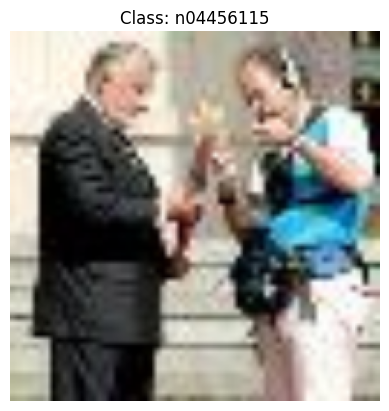

In [8]:
#test
unnormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406],
                               [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

img_display = unnormalize(tensor_img).clamp(0, 1).permute(1, 2, 0).numpy()

plt.imshow(img_display)
plt.title(f"Class: {cls}")
plt.axis("off")
plt.show()


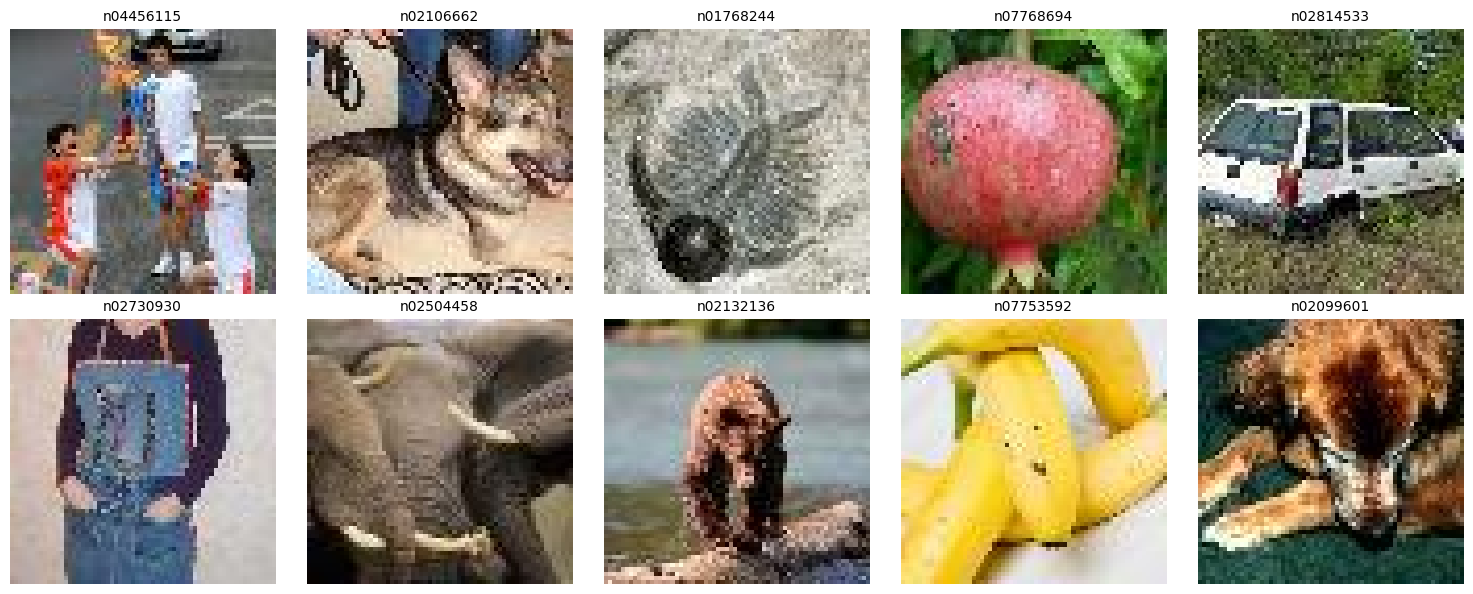

classes for the training set： {'n04456115': 100, 'n02106662': 100, 'n01768244': 100, 'n07768694': 100, 'n02814533': 100, 'n02730930': 100, 'n02504458': 100, 'n02132136': 100, 'n07753592': 100, 'n02099601': 100}
class for the validation set： {'n04456115': 20, 'n02106662': 20, 'n01768244': 20, 'n07768694': 20, 'n02814533': 20, 'n02730930': 20, 'n02504458': 20, 'n02132136': 20, 'n07753592': 20, 'n02099601': 20}


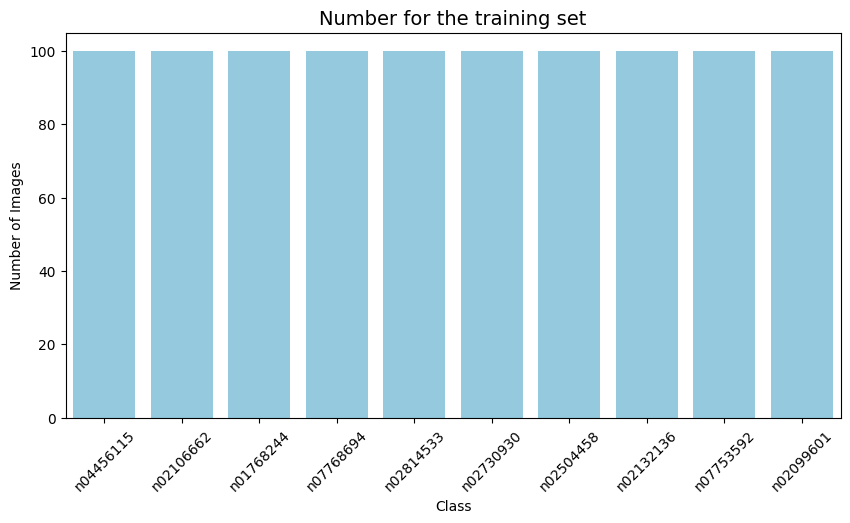

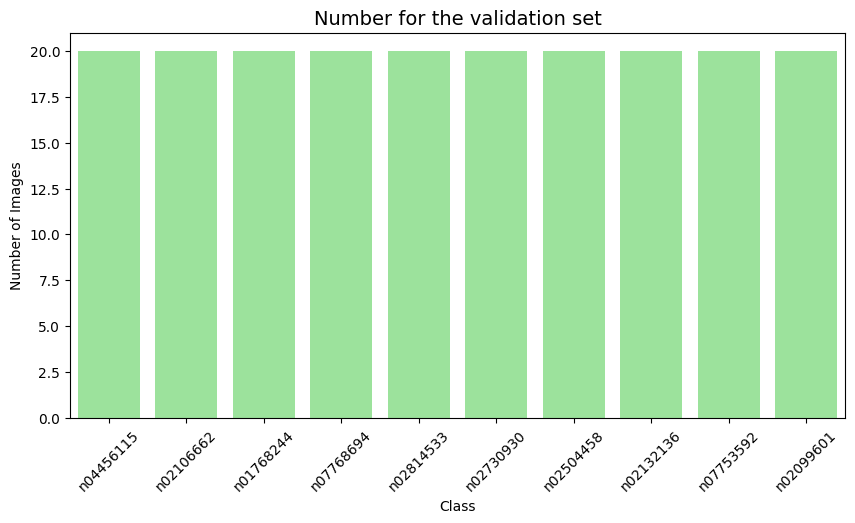

In [9]:
# --- Visualize a random training image for each class ---
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, cls in zip(axes.flatten(), sampled_train.keys()):
    img_path = os.path.join(TRAIN_DIR, cls, "images", random.choice(sampled_train[cls]))
    img = Image.open(img_path).convert("RGB")


    ax.imshow(img)
    ax.set_title(cls, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

# --- Print the number of samples for each class. ---

train_counts = {cls: len(sampled_train[cls]) for cls in sampled_train}
val_counts = {cls: len(sampled_val[cls]) for cls in sampled_val}

print("classes for the training set：", train_counts)
print("class for the validation set：", val_counts)


# --- bar chart of sample distribution ---
plt.figure(figsize=(10, 5))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), color='skyblue')
plt.title("Number for the training set", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=list(val_counts.keys()), y=list(val_counts.values()), color='lightgreen')
plt.title("Number for the validation set", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [11]:
weights = VGG16_Weights.IMAGENET1K_V1
vgg = vgg16(weights=weights)

vgg = vgg.to(device)
vgg.eval()
print(f"Loaded vgg16 with ImageNet weights on {device}.")


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 82.3MB/s]


Loaded vgg16 with ImageNet weights on cpu.


In [12]:
for p in vgg.parameters():
    p.requires_grad = False

# self check False
sum_requires_grad = sum(int(p.requires_grad) for p in vgg.parameters())
print("Trainable parameters count (should be 0):", sum_requires_grad)


Trainable parameters count (should be 0): 0


In [13]:
x_dummy = torch.randn(2, 3, 224, 224, device=device)
with torch.no_grad():
    logits = vgg(x_dummy)

print("Output shape:", logits.shape)


Output shape: torch.Size([2, 1000])


In [14]:
total_params = sum(p.numel() for p in vgg.parameters())
trainable_params = sum(p.numel() for p in vgg.parameters() if p.requires_grad)
print(f"Total params: {total_params:,}")
print(f"Trainable params (should be 0): {trainable_params:,}")


Total params: 138,357,544
Trainable params (should be 0): 0


In [15]:
# 指定想要的中间层节点
return_nodes = {
    'features.16': 'conv3_out',   # Conv3模块
    'features.23': 'conv4_out',   # Conv4模块
    'avgpool':     'avgpool_out'  # 平均池化层
}

extractor = create_feature_extractor(vgg, return_nodes=return_nodes).to(device)


In [16]:
def extract_features(x):
    with torch.no_grad():  # 不计算梯度
        outputs = extractor(x)

        # 取出各层特征
        conv3 = outputs['conv3_out']   # [B, 256, 28, 28]
        conv4 = outputs['conv4_out']   # [B, 512, 14, 14]
        avgp  = outputs['avgpool_out'] # [B, 512, 7, 7]

        # 对 Conv3/Conv4 进行 GAP（全局平均池化）
        conv3_vec = F.adaptive_avg_pool2d(conv3, 1).flatten(1)  # [B, 256]
        conv4_vec = F.adaptive_avg_pool2d(conv4, 1).flatten(1)  # [B, 512]
        avgp_vec  = avgp.flatten(1)   # [B, 25088]

        return conv3_vec, conv4_vec, avgp_vec


In [17]:
SAVE_ROOT = "/content/drive/MyDrive/402_CW1_PartB/features"
os.makedirs(SAVE_ROOT, exist_ok=True)

print("Saving features to:", SAVE_ROOT)

Saving features to: /content/drive/MyDrive/402_CW1_PartB/features


In [18]:
class TinyImageNetSubset(Dataset):
    def __init__(self, df, mode="train", transform=None):
        self.df = df
        self.mode = mode
        self.transform = transform
        if mode == "train":
            self.root = TRAIN_DIR
        else:
            self.root = VAL_DIR

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        cls_name, img_name = self.df.iloc[idx]
        if self.mode == "train":
            img_path = os.path.join(self.root, cls_name, "images", img_name)
        else:
            img_path = os.path.join(self.root, "images", img_name)

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, cls_name, img_name

In [19]:
batch_size = 32

train_dataset = TinyImageNetSubset(train_df, mode="train", transform=transform)
val_dataset   = TinyImageNetSubset(val_df, mode="val",   transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [20]:
from tqdm import tqdm

def extract_and_cache(loader, save_prefix):
    conv3_all = []
    conv4_all = []
    avgp_all = []


    for imgs, cls_names, img_names in tqdm(loader, desc=f"Extracting {save_prefix}"):
        imgs = imgs.to(device)

        conv3_vec, conv4_vec, avgp_vec = extract_features(imgs)

        conv3_all.append(conv3_vec.cpu())
        conv4_all.append(conv4_vec.cpu())
        avgp_all.append(avgp_vec.cpu())


    conv3_all = torch.cat(conv3_all, dim=0)
    conv4_all = torch.cat(conv4_all, dim=0)
    avgp_all = torch.cat(avgp_all, dim=0)


    torch.save(conv3_all, os.path.join(SAVE_ROOT, f"{save_prefix}_conv3.pt"))
    torch.save(conv4_all, os.path.join(SAVE_ROOT, f"{save_prefix}_conv4.pt"))
    torch.save(avgp_all, os.path.join(SAVE_ROOT, f"{save_prefix}_avgpool.pt"))

    print(f"\nSaved features for {save_prefix}:")
    print(" conv3:", conv3_all.shape)
    print(" conv4:", conv4_all.shape)
    print(" avgp:", avgp_all.shape)


extract_and_cache(train_loader, "train")
extract_and_cache(val_loader, "val")


Extracting train: 100%|██████████| 32/32 [16:20<00:00, 30.63s/it]



Saved features for train:
 conv3: torch.Size([1000, 256])
 conv4: torch.Size([1000, 512])
 avgp: torch.Size([1000, 25088])


Extracting val: 100%|██████████| 7/7 [03:15<00:00, 27.92s/it]



Saved features for val:
 conv3: torch.Size([200, 256])
 conv4: torch.Size([200, 512])
 avgp: torch.Size([200, 25088])


In [21]:
FEATURE_ROOT = "/content/drive/MyDrive/402_CW1_PartB/features"

train_conv3 = torch.load(os.path.join(FEATURE_ROOT, "train_conv3.pt"))  # [1000, 256]
train_conv4 = torch.load(os.path.join(FEATURE_ROOT, "train_conv4.pt"))  # [1000, 512]
train_avgp = torch.load(os.path.join(FEATURE_ROOT, "train_avgpool.pt")) # [1000, 25088]

val_conv3 = torch.load(os.path.join(FEATURE_ROOT, "val_conv3.pt"))      # [200, 256]
val_conv4 = torch.load(os.path.join(FEATURE_ROOT, "val_conv4.pt"))      # [200, 512]
val_avgp = torch.load(os.path.join(FEATURE_ROOT, "val_avgpool.pt"))     # [200, 25088]

print(train_conv3.shape, val_conv3.shape)
print(train_conv4.shape, val_conv4.shape)
print(train_avgp.shape, val_avgp.shape)

torch.Size([1000, 256]) torch.Size([200, 256])
torch.Size([1000, 512]) torch.Size([200, 512])
torch.Size([1000, 25088]) torch.Size([200, 25088])


In [22]:
print(len(train_df), len(val_df))

le = LabelEncoder()
le.fit(train_df["class"].values)

y_train = le.transform(train_df["class"].values)
y_val   = le.transform(val_df["class"].values)

print("Classes:", list(le.classes_))
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

1000 200
Classes: ['n01768244', 'n02099601', 'n02106662', 'n02132136', 'n02504458', 'n02730930', 'n02814533', 'n04456115', 'n07753592', 'n07768694']
y_train shape: (1000,)
y_val shape: (200,)


In [23]:
X_train_conv3 = train_conv3.numpy()
X_train_conv4 = train_conv4.numpy()
X_train_avgp  = train_avgp.numpy()

X_val_conv3 = val_conv3.numpy()
X_val_conv4 = val_conv4.numpy()
X_val_avgp  = val_avgp.numpy()

print("X_train_conv3:", X_train_conv3.shape)
print("X_train_conv4:", X_train_conv4.shape)
print("X_train_avgp :", X_train_avgp.shape)


X_train_conv3: (1000, 256)
X_train_conv4: (1000, 512)
X_train_avgp : (1000, 25088)


In [24]:
from sklearn.decomposition import PCA

print("Applying PCA...")

# Conv3 PCA
pca_conv3 = PCA(n_components=64, random_state=42)
X_train_conv3_pca = pca_conv3.fit_transform(X_train_conv3)
X_val_conv3_pca = pca_conv3.transform(X_val_conv3)
print("Conv3 PCA:", X_train_conv3_pca.shape, X_val_conv3_pca.shape)

# Conv4 PCA
pca_conv4 = PCA(n_components=128, random_state=42)
X_train_conv4_pca = pca_conv4.fit_transform(X_train_conv4)
X_val_conv4_pca = pca_conv4.transform(X_val_conv4)
print("Conv4 PCA:", X_train_conv4_pca.shape, X_val_conv4_pca.shape)

# AvgPool PCA
pca_avgp = PCA(n_components=512, random_state=42)
X_train_avgp_pca = pca_avgp.fit_transform(X_train_avgp)
X_val_avgp_pca = pca_avgp.transform(X_val_avgp)
print("AvgPool PCA:", X_train_avgp_pca.shape, X_val_avgp_pca.shape)


Applying PCA...
Conv3 PCA: (1000, 64) (200, 64)
Conv4 PCA: (1000, 128) (200, 128)
AvgPool PCA: (1000, 512) (200, 512)


In [27]:


rf_conv3 = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_conv4 = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_avgp = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

print("Training RF models on original features...")
rf_conv3.fit(X_train_conv3, y_train)
rf_conv4.fit(X_train_conv4, y_train)
rf_avgp.fit(X_train_avgp, y_train)




rf_conv3_pca = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_conv4_pca = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_avgp_pca = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

print("Training RF models on PCA-reduced features...")
rf_conv3_pca.fit(X_train_conv3_pca, y_train)
rf_conv4_pca.fit(X_train_conv4_pca, y_train)
rf_avgp_pca.fit(X_train_avgp_pca, y_train)

print("Training done.")


Training RF models on original features...
Training RF models on PCA-reduced features...
Training done.


In [28]:
def evaluate_single_model(model, X_val, y_val, name="model"):
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"{name} Accuracy on 200 val images: {acc:.4f}")
    return acc

acc_conv3 = evaluate_single_model(rf_conv3, X_val_conv3, y_val, "RF Conv3")
acc_conv4 = evaluate_single_model(rf_conv4, X_val_conv4, y_val, "RF Conv4")
acc_avgp  = evaluate_single_model(rf_avgp, X_val_avgp,  y_val, "RF AvgPool")

acc_conv3_pca = accuracy_score(y_val, rf_conv3_pca.predict(X_val_conv3_pca))
acc_conv4_pca = accuracy_score(y_val, rf_conv4_pca.predict(X_val_conv4_pca))
acc_avgp_pca = accuracy_score(y_val, rf_avgp_pca.predict(X_val_avgp_pca))

print("Conv3 PCA Acc:", acc_conv3_pca)
print("Conv4 PCA Acc:", acc_conv4_pca)
print("AvgPool PCA Acc:", acc_avgp_pca)



RF Conv3 Accuracy on 200 val images: 0.6200
RF Conv4 Accuracy on 200 val images: 0.7700
RF AvgPool Accuracy on 200 val images: 0.8500
Conv3 PCA Acc: 0.625
Conv4 PCA Acc: 0.805
AvgPool PCA Acc: 0.815


In [29]:
proba_conv3 = rf_conv3.predict_proba(X_val_conv3)
proba_conv4 = rf_conv4.predict_proba(X_val_conv4)
proba_avgp  = rf_avgp.predict_proba(X_val_avgp)

proba_ensemble = (proba_conv3 + proba_conv4 + proba_avgp) / 3.0

y_pred_ensemble = np.argmax(proba_ensemble, axis=1)

ensemble_acc = accuracy_score(y_val, y_pred_ensemble)
print(f"Ensemble (probability averaging) Accuracy on 200 val images: {ensemble_acc:.4f}")


Ensemble (probability averaging) Accuracy on 200 val images: 0.8150


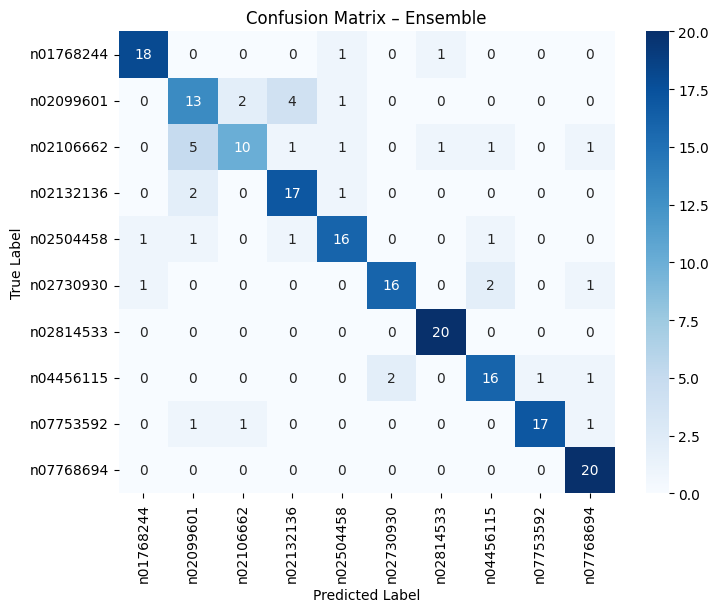

In [30]:
cm = confusion_matrix(y_val, y_pred_ensemble)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Ensemble")
plt.show()

In [31]:
print("\nClassification report for ensemble:")
print(classification_report(y_val, y_pred_ensemble, target_names=le.classes_))



Classification report for ensemble:
              precision    recall  f1-score   support

   n01768244       0.90      0.90      0.90        20
   n02099601       0.59      0.65      0.62        20
   n02106662       0.77      0.50      0.61        20
   n02132136       0.74      0.85      0.79        20
   n02504458       0.80      0.80      0.80        20
   n02730930       0.89      0.80      0.84        20
   n02814533       0.91      1.00      0.95        20
   n04456115       0.80      0.80      0.80        20
   n07753592       0.94      0.85      0.89        20
   n07768694       0.83      1.00      0.91        20

    accuracy                           0.81       200
   macro avg       0.82      0.82      0.81       200
weighted avg       0.82      0.81      0.81       200



In [32]:
rng = np.random.RandomState(123)


feature_views_train = {
    "conv3": X_train_conv3,   # shape: [1000, 256]
    "conv4": X_train_conv4,   # shape: [1000, 512]
    "avgp": X_train_avgp      # shape: [1000, 25088]
}

feature_views_val = {
    "conv3": X_val_conv3,     # shape: [200, 256]
    "conv4": X_val_conv4,     # shape: [200, 512]
    "avgp": X_val_avgp        # shape: [200, 25088]
}

n_train = X_train_conv3.shape[0]   # 1000
print("n_train =", n_train)


n_train = 1000


In [33]:
num_trees = 20

trees = []       # save tree
tree_views = []  # feature view（conv3/conv4/avgp）

for t in range(num_trees):
    # random choice wchic tree use what feature view
    view_name = rng.choice(["conv3", "conv4", "avgp"])
    X_view = feature_views_train[view_name]

    #  do bootstrap for 1000
    indices = rng.choice(n_train, size=n_train, replace=True)
    X_boot = X_view[indices]
    y_boot = y_train[indices]

    # singel tree
    clf = DecisionTreeClassifier(
        max_depth=None,
        random_state=100 + t
    )
    clf.fit(X_boot, y_boot)

    trees.append(clf)
    tree_views.append(view_name)

    print(f"Trained tree {t+1}/{num_trees} using view = {view_name}, bootstrap size = {len(indices)}")


Trained tree 1/20 using view = avgp, bootstrap size = 1000
Trained tree 2/20 using view = avgp, bootstrap size = 1000
Trained tree 3/20 using view = conv3, bootstrap size = 1000
Trained tree 4/20 using view = avgp, bootstrap size = 1000
Trained tree 5/20 using view = conv3, bootstrap size = 1000
Trained tree 6/20 using view = conv4, bootstrap size = 1000
Trained tree 7/20 using view = conv4, bootstrap size = 1000
Trained tree 8/20 using view = conv4, bootstrap size = 1000
Trained tree 9/20 using view = avgp, bootstrap size = 1000
Trained tree 10/20 using view = conv4, bootstrap size = 1000
Trained tree 11/20 using view = avgp, bootstrap size = 1000
Trained tree 12/20 using view = avgp, bootstrap size = 1000
Trained tree 13/20 using view = conv4, bootstrap size = 1000
Trained tree 14/20 using view = avgp, bootstrap size = 1000
Trained tree 15/20 using view = conv3, bootstrap size = 1000
Trained tree 16/20 using view = avgp, bootstrap size = 1000
Trained tree 17/20 using view = conv3, bo

In [34]:
# collect every tree on val
all_proba = []

for clf, view_name in zip(trees, tree_views):
    X_val_view = feature_views_val[view_name]
    proba = clf.predict_proba(X_val_view)  # shape: [200, 10]
    all_proba.append(proba)

# [num_trees, 200, 10]
all_proba = np.stack(all_proba, axis=0)

print("all_proba shape:", all_proba.shape)  # (num_trees, 200, num_classes)

# num_trees dim averaged --- probability average
proba_ensemble_b4 = all_proba.mean(axis=0)  # [200, 10]

# take highest probability
y_pred_ensemble_b4 = np.argmax(proba_ensemble_b4, axis=1)

b4_acc = accuracy_score(y_val, y_pred_ensemble_b4)
print(f"Ensemble (Different Data + Different Features) Accuracy on 200 val images: {b4_acc:.4f}")


all_proba shape: (20, 200, 10)
Ensemble (Different Data + Different Features) Accuracy on 200 val images: 0.7450


In [35]:
print("y_val shape:", y_val.shape)

acc_A = accuracy_score(y_val, y_pred_ensemble)       # B.3
acc_B = accuracy_score(y_val, y_pred_ensemble_b4)    # B.4

print(f"Ensemble A (B.3) Accuracy: {acc_A:.4f}")
print(f"Ensemble B (B.4) Accuracy: {acc_B:.4f}")

f1_A_per_class = f1_score(y_val, y_pred_ensemble, average=None)
f1_B_per_class = f1_score(y_val, y_pred_ensemble_b4, average=None)

class_names = le.classes_

print("\nPer-class F1 scores:")
for cls_name, f1_a, f1_b in zip(class_names, f1_A_per_class, f1_B_per_class):
    print(f"Class {cls_name:>10s} | F1_A = {f1_a:.4f} | F1_B = {f1_b:.4f}")

print("\nDetailed report for Ensemble A:")
print(classification_report(y_val, y_pred_ensemble, target_names=class_names))

print("\nDetailed report for Ensemble B:")
print(classification_report(y_val, y_pred_ensemble_b4, target_names=class_names))

y_val shape: (200,)
Ensemble A (B.3) Accuracy: 0.8150
Ensemble B (B.4) Accuracy: 0.7450

Per-class F1 scores:
Class  n01768244 | F1_A = 0.9000 | F1_B = 0.7442
Class  n02099601 | F1_A = 0.6190 | F1_B = 0.7027
Class  n02106662 | F1_A = 0.6061 | F1_B = 0.6471
Class  n02132136 | F1_A = 0.7907 | F1_B = 0.7143
Class  n02504458 | F1_A = 0.8000 | F1_B = 0.6667
Class  n02730930 | F1_A = 0.8421 | F1_B = 0.7179
Class  n02814533 | F1_A = 0.9524 | F1_B = 0.8837
Class  n04456115 | F1_A = 0.8000 | F1_B = 0.7000
Class  n07753592 | F1_A = 0.8947 | F1_B = 0.8421
Class  n07768694 | F1_A = 0.9091 | F1_B = 0.8205

Detailed report for Ensemble A:
              precision    recall  f1-score   support

   n01768244       0.90      0.90      0.90        20
   n02099601       0.59      0.65      0.62        20
   n02106662       0.77      0.50      0.61        20
   n02132136       0.74      0.85      0.79        20
   n02504458       0.80      0.80      0.80        20
   n02730930       0.89      0.80      0.8

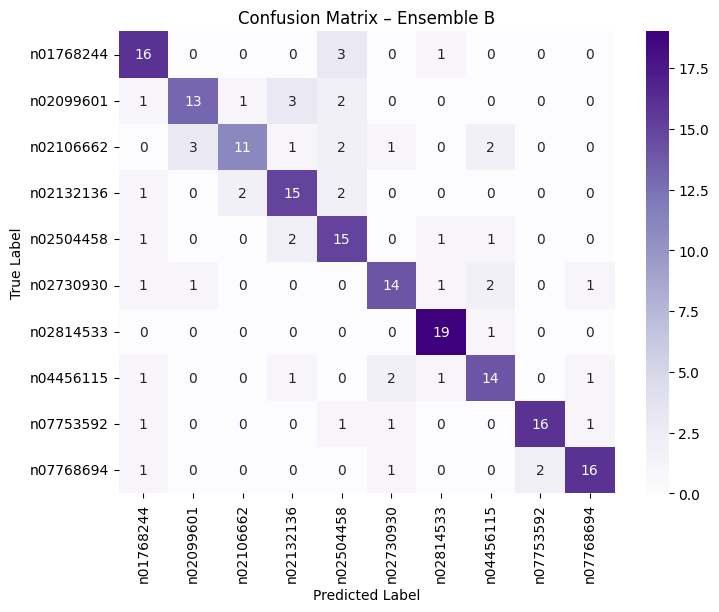

In [36]:
cm_B = confusion_matrix(y_val, y_pred_ensemble_b4)

plt.figure(figsize=(8,6))
sns.heatmap(cm_B, annot=True, fmt="d", cmap="Purples",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Ensemble B")
plt.show()

In [37]:
def run_ensemble_B(num_trees=10, random_state=123):
    rng = np.random.RandomState(random_state)

    n_train = list(feature_views_train.values())[0].shape[0]  # 1000
    trees = []
    tree_views = []

    for t in range(num_trees):
        # random choice
        view_name = rng.choice(["conv3", "conv4", "avgp"])
        X_view_train = feature_views_train[view_name]

        # bootstrap
        indices = rng.choice(n_train, size=n_train, replace=True)
        X_boot = X_view_train[indices]
        y_boot = y_train[indices]

        # tree
        clf = DecisionTreeClassifier(
            max_depth=None,
            random_state=100 + t
        )
        clf.fit(X_boot, y_boot)

        trees.append(clf)
        tree_views.append(view_name)

    # val ensemble predi
    all_proba = []
    for clf, view_name in zip(trees, tree_views):
        X_val_view = feature_views_val[view_name]
        proba = clf.predict_proba(X_val_view)   # [200, num_classes]
        all_proba.append(proba)

    all_proba = np.stack(all_proba, axis=0)    # [num_trees, 200, num_classes]
    proba_ens = all_proba.mean(axis=0)         # [200, num_classes]
    y_pred = np.argmax(proba_ens, axis=1)

    acc = accuracy_score(y_val, y_pred)
    return acc, y_pred

In [38]:
tree_list = [1, 3, 5, 10, 15, 20]
results = {}

for n_trees in tree_list:
    acc, _ = run_ensemble_B(num_trees=n_trees, random_state=123)
    results[n_trees] = acc
    print(f"Ensemble B with {n_trees:2d} trees → Accuracy on 200 val images: {acc:.4f}")


Ensemble B with  1 trees → Accuracy on 200 val images: 0.5100
Ensemble B with  3 trees → Accuracy on 200 val images: 0.5450
Ensemble B with  5 trees → Accuracy on 200 val images: 0.6150
Ensemble B with 10 trees → Accuracy on 200 val images: 0.6900
Ensemble B with 15 trees → Accuracy on 200 val images: 0.7550
Ensemble B with 20 trees → Accuracy on 200 val images: 0.7450


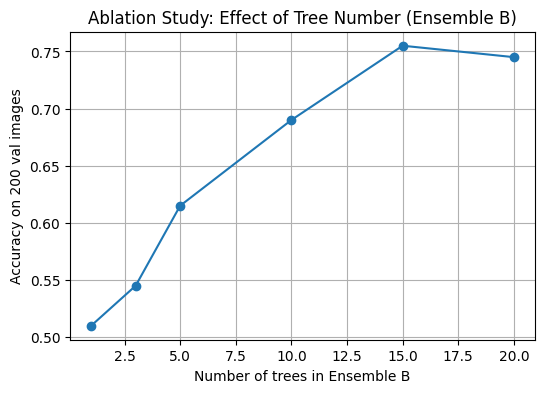

In [39]:
xs = list(results.keys())
ys = [results[k] for k in xs]

plt.figure(figsize=(6,4))
plt.plot(xs, ys, marker="o")
plt.xlabel("Number of trees in Ensemble B")
plt.ylabel("Accuracy on 200 val images")
plt.title("Ablation Study: Effect of Tree Number (Ensemble B)")
plt.grid(True)
plt.show()

In [40]:
results_table = {
    "Model": ["Ensemble A", "Ensemble B"],
    "Accuracy": [acc_A, acc_B],
    "Macro F1": [
        f1_score(y_val, y_pred_ensemble, average="macro"),
        f1_score(y_val, y_pred_ensemble_b4, average="macro")
    ]
}

df_results = pd.DataFrame(results_table)
print(df_results)

# Ablation
ablation_rows = []
for n_trees in tree_list:
    acc, y_pred = run_ensemble_B(num_trees=n_trees, random_state=123)
    macro_f1 = f1_score(y_val, y_pred, average="macro")

    ablation_rows.append({
        "Model": f"Ablation ({n_trees} trees)",
        "Accuracy": acc,
        "Macro F1": macro_f1
    })

df_ablation = pd.DataFrame(ablation_rows)


df_final = pd.concat([df_results, df_ablation], ignore_index=True)
print("\nCompact Results Table:")
print(df_final)

        Model  Accuracy  Macro F1
0  Ensemble A     0.815  0.811412
1  Ensemble B     0.745  0.743919

Compact Results Table:
                 Model  Accuracy  Macro F1
0           Ensemble A     0.815  0.811412
1           Ensemble B     0.745  0.743919
2   Ablation (1 trees)     0.510  0.506490
3   Ablation (3 trees)     0.545  0.546605
4   Ablation (5 trees)     0.615  0.612645
5  Ablation (10 trees)     0.690  0.685695
6  Ablation (15 trees)     0.755  0.753656
7  Ablation (20 trees)     0.745  0.743919
